In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

data_url = './csicFinal.csv'
data = pd.read_csv(data_url)

# Drop de colunas contem os mesmos valores (redundantes)
redundant_columns = ['Pragma', 'Host-Header', 'Connection', 'Accept', 'Accept-Charset', 'Accept-Language', 'Cache-control']
for var in redundant_columns:
    data.drop(var, axis = 1, inplace = True)


# Remocao Cookies: Apos observar no terminal usando a funcao
# print(data['Cookie'].value_counts())
# Percebe-se que cada coluna contem um valor de cookie diferente.
# Como cada coluna tem um valor de Cookie diferente para cada uma, me parece mais ser um identificador
# Ou seja, uma variavel que nao ira ajudar em detectar ser uma anomalia ou nao, optando por remove-la
data.drop('Cookie', axis = 1, inplace = True)



In [57]:
# Conversao variaveis categoricas em numericas para
from sklearn.preprocessing import OneHotEncoder

one_hot_enconder_columns = OneHotEncoder()

# One Hot Enconder
# Substituicao de valores NaN por 0
data["Content-Length"].fillna(0, inplace=True)

# Count recebe quantidade de linhas que contem cada valor
count = data["Content-Length"].value_counts()

# Condicao recebe uma tabela com valores booleanos representando se a linha contem valor maior que N
condition = count.gt(500)

# Data recebe apenas valores que passaram na condicao acima
data = data[data["Content-Length"].isin(count.index[condition])]


# feature_array recebe matriz com a encodificacao one hot
columns_to_OHE = ["Method", "Host", "Class", "Content-Length"]
feature_array = one_hot_enconder_columns.fit_transform(data[columns_to_OHE]).toarray()

# feature_labels recebe as categorias da matriz criada
feature_labels = one_hot_enconder_columns.categories_

# Concatena as categorias de todas as colunas
concatenated_categories = np.concatenate(feature_labels)

# DataFrame com as colunas de categorias + matriz de dados OHE
df_OHE = pd.DataFrame(feature_array, columns=concatenated_categories)

# Concatenacao dos dados com OHE
data_final = pd.concat([data, df_OHE], axis = 1)

# Colunas com valores string que serao descartados
string_columns = ["Content-Type", "URI", "POST-Data", "GET-Query"]
columns_to_drop = columns_to_OHE + string_columns + ["Anomalous"]

# Remocao das colunas com valores categoricos
for var in columns_to_drop:
    data_final.drop(var, axis = 1, inplace = True)

# Remocao de linhas com valores nao numericos (NaN)
data_final.dropna(axis=0, inplace=True)

display(data_final)


,GET,POST,PUT,localhost:8080,localhost:9090,Valid,0.0,4.0,17.0,33.0,38.0,43.0
0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
6,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
47279,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
47281,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
47286,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
47288,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [91]:
# Separacao de features e class
y_columns = ['Valid']
X = data_final.drop(y_columns, axis = 1)
y = data_final[y_columns]

# Correlacao da feature com a class
# Valores proximos de +1.0 indicam relacao positiva para a classe ser Valida (sem anomalia)
# Valores proximos de -0.1 indicam relacao positiva para a classe ser uma Anomalia
correlation = data_final.corr()
correlation["Valid"].sort_values(ascending=False)



Valid             1.000000
POST              0.190317
17.0              0.090355
33.0              0.088369
4.0               0.087629
localhost:8080    0.086213
43.0              0.043253
38.0              0.040195
PUT              -0.086213
localhost:9090   -0.086213
0.0              -0.168738
GET              -0.168738
Name: Valid, dtype: float64

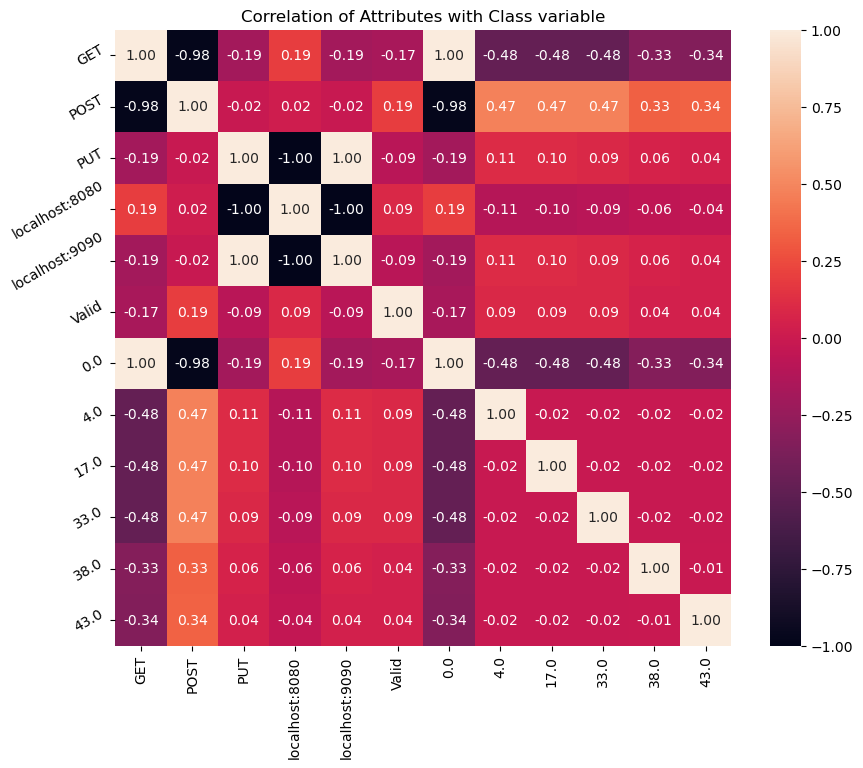

In [92]:
# Plot do grafico de correlacao 
plt.figure(figsize=(10,8))
plt.title('Correlation of Attributes with Class variable')
a = sns.heatmap(correlation, square=True, annot=True, fmt='.2f', linecolor='white')
a.set_xticklabels(a.get_xticklabels(), rotation=90)
a.set_yticklabels(a.get_yticklabels(), rotation=30)           
plt.show()

In [93]:
from sklearn.model_selection import train_test_split
                                                        #teste_size: % de dados para teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9,random_state=0)

X_train.columns =  X_train.columns.astype(str) 
X_test.columns =  X_test.columns.astype(str) 

In [97]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=20)

knn.fit(X_train, y_train)

y_predict = knn.predict(X_test)

y_predict

d:\ProgramFiles\Anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


array([1., 1., 1., ..., 1., 1., 1.])

In [98]:
# Probabilidade de ser uma sessao valida cada caso de teste:
knn.predict_proba(X_test)[:,1]

array([0.6, 0.6, 1. , ..., 0.6, 0.6, 1. ])

In [99]:
from sklearn.metrics import accuracy_score

# Precisao do modelo com dados de teste
print("Precisao do modelo com dados de teste: {0:0.4f}" .format(accuracy_score(y_test, y_predict)))

Model accuracy score: 0.6781


In [100]:
# Precisao do modelo com dados de treino

y_pred_train = knn.predict(X_train)

print('Precisao do modelo com dados de treino: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

Training-set accuracy score: 0.6777


In [102]:
# Precisao nula
# A precisão nula é a precisão que poderia ser alcançada por sempre prever a classe mais frequente.

y_test.value_counts()
null_accuracy = (28711/(28711+13851))

print('Null accuracy score: {0:0.4f}'. format(null_accuracy))

Null accuracy score: 0.6746
